In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pandas as pd
import email
import email.policy
import tarfile

# Importing Files from Foogle Drive
file_path = '/content/drive/My Drive/MSDS422Group3/Group Project/enron_mail_20150507.tar.gz'

#file_path = 'enron_mail_20150507.tar.gz'

# Extract the tar.gz file
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall()

# Function to parse a single email file
def parse_email(file_path):
    try:
        with open(file_path, 'r', encoding='latin1') as file:
            email_content = email.message_from_file(file, policy=email.policy.default)
            return {
                "From": email_content['From'],
                "To": email_content['To'],
                "Subject": email_content['Subject'],
                "Date": email_content['Date'],
                "Body": email_content.get_payload(decode=True)
            }
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Directory where the emails are found after extraction
email_dir = '/content/maildir'

# Function to get a generator of file paths
def file_path_generator(email_dir, max_files=None):
    file_paths = []
    for root, _, files in os.walk(email_dir):
        for file_name in files:
            file_paths.append(os.path.join(root, file_name))
            if max_files and len(file_paths) >= max_files:
                break
        if max_files and len(file_paths) >= max_files:
            break
    return file_paths


max_files_to_process = 10000

all_file_paths = file_path_generator(email_dir, max_files=max_files_to_process)
sampled_file_paths = random.sample(all_file_paths, k=max_files_to_process)


parsed_emails = [parse_email(path) for path in sampled_file_paths if parse_email(path) is not None]

df_emails = pd.DataFrame(parsed_emails)

# Display
print(df_emails.head())

                                From  \
0      enron.announcements@enron.com   
1              a..shankman@enron.com   
2  vic.gatto@owen2002.vanderbilt.edu   
3             chance.rabon@enron.com   
4            jeff.bartlett@enron.com   

                                                  To  \
0                            all.worldwide@enron.com   
1                 pruskin@purskingallery.demon.co.uk   
2                              harry.arora@enron.com   
3  chuck.ames@enron.com, f..brawner@enron.com, ku...   
4                              harry.arora@enron.com   

                                             Subject  \
0         Espeak with Fitness Expert, Dr. Joel Bloom   
1                                                      
2                                          Thank You   
3  TRV Notification:  (East P/L Totals - 11/20/2001)   
4                    JMB Deal Summary Sheet for 2000   

                              Date  \
0  Sun, 13 May 2001 12:37:00 -0700   
1  Tue, 0

In [ ]:
# EDA Parts 1 & 2
# Conversion of the byte strings in the 'Body' column to regular strings
# Parsing the 'Date' column into a datetime format

# Byte strings Converstions
df_emails['Body'] = df_emails['Body'].apply(lambda x: x.decode('utf-8', errors='ignore') if isinstance(x, bytes) else x)

# Parse 'Date' column into datetime
df_emails['Date'] = pd.to_datetime(df_emails['Date'], errors='coerce', utc=True)

# Display
print(df_emails.head())

                                From  \
0      enron.announcements@enron.com   
1              a..shankman@enron.com   
2  vic.gatto@owen2002.vanderbilt.edu   
3             chance.rabon@enron.com   
4            jeff.bartlett@enron.com   

                                                  To  \
0                            all.worldwide@enron.com   
1                 pruskin@purskingallery.demon.co.uk   
2                              harry.arora@enron.com   
3  chuck.ames@enron.com, f..brawner@enron.com, ku...   
4                              harry.arora@enron.com   

                                             Subject  \
0         Espeak with Fitness Expert, Dr. Joel Bloom   
1                                                      
2                                          Thank You   
3  TRV Notification:  (East P/L Totals - 11/20/2001)   
4                    JMB Deal Summary Sheet for 2000   

                       Date                                               Body  
0 20

In [ ]:
# Cleaning
df_emails['Body'] = df_emails['Body'].str.replace(r'\s+', ' ', regex=True)
df_emails['Subject'] = df_emails['Subject'].str.replace(r'\s+', ' ', regex=True)

print("Total emails:", df_emails.shape[0])
print("Unique senders:", df_emails['From'].nunique())
print("Unique recipients:", df_emails['To'].nunique())

from collections import Counter
import re

words = Counter(" ".join(df_emails['Body']).split()).most_common(10)
print("Most common words in the Body:", words)

df_emails['Date'] = pd.to_datetime(df_emails['Date'], utc=True)
df_emails.set_index('Date', inplace=True)
print(df_emails.resample('M').size())

Total emails: 10000
Unique senders: 1058
Unique recipients: 1854
Most common words in the Body: [('the', 87057), ('to', 63483), ('and', 47426), ('of', 41628), ('a', 33331), ('in', 29795), ('for', 25169), ('>', 23091), ('on', 20698), ('you', 20517)]
Date
1980-01-31 00:00:00+00:00    8
1980-02-29 00:00:00+00:00    0
1980-03-31 00:00:00+00:00    0
1980-04-30 00:00:00+00:00    0
1980-05-31 00:00:00+00:00    0
                            ..
2043-09-30 00:00:00+00:00    0
2043-10-31 00:00:00+00:00    0
2043-11-30 00:00:00+00:00    0
2043-12-31 00:00:00+00:00    1
2044-01-31 00:00:00+00:00    3
Freq: M, Length: 769, dtype: int64


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stop_words(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

df_emails['Body'] = df_emails['Body'].apply(remove_stop_words)

words = Counter(" ".join(df_emails['Body']).split()).most_common(10)
print("Most common words in the Body (without stop words):", words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Most common words in the Body (without stop words): [(',', 146375), ('.', 104018), ('--', 92674), (':', 66112), ('>', 64211), ('*', 62403), ('@', 42733), ('<', 36305), ("''", 25810), (')', 22343)]


In [ ]:
import string
import re
from collections import Counter

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word.isalpha()]
    return " ".join(tokens)

df_emails['Body'] = df_emails['Body'].apply(clean_text)

words = Counter(" ".join(df_emails['Body']).split()).most_common(10)
print("Most common words in the Body (cleaned):", words)


Most common words in the Body (cleaned): [('enron', 26044), ('ect', 15849), ('pm', 8953), ('subject', 8514), ('please', 7351), ('td', 7317), ('font', 6212), ('would', 5987), ('cc', 5340), ('company', 5155)]


Most common words in the Body (cleaned): [('enron', 26044), ('ect', 15849), ('pm', 8953), ('subject', 8514), ('please', 7351), ('td', 7317), ('font', 6212), ('would', 5987), ('cc', 5340), ('company', 5155), ('email', 5152), ('new', 5127), ('message', 5059), ('http', 5009), ('nt', 4829), ('jeffrey', 4669), ('us', 4645), ('time', 4474), ('sent', 4400), ('enroncom', 4255), ('said', 4082), ('original', 3950), ('know', 3947), ('may', 3884), ('john', 3773), ('jeff', 3735), ('thanks', 3710), ('one', 3677), ('gas', 3647), ('get', 3572)]


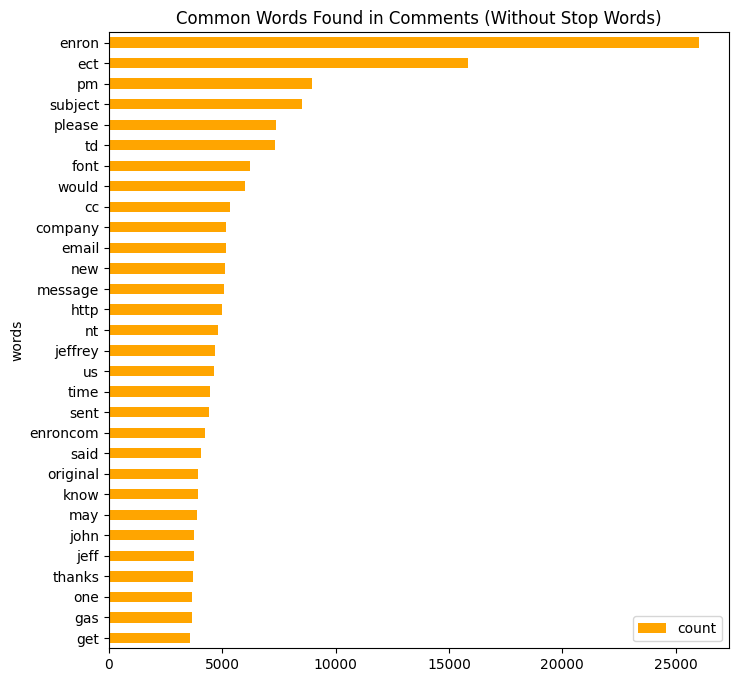

In [ ]:
words2 = Counter(" ".join(df_emails['Body']).split()).most_common(30)
print("Most common words in the Body (cleaned):", words2)

clean_words = pd.DataFrame(words2,
                             columns=['words', 'count'])
#clean_words

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_words.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="orange")

ax.set_title("Common Words Found in Comments (Without Stop Words)")

plt.show()

AttributeError: 'Series' object has no attribute 'DateFormatter'

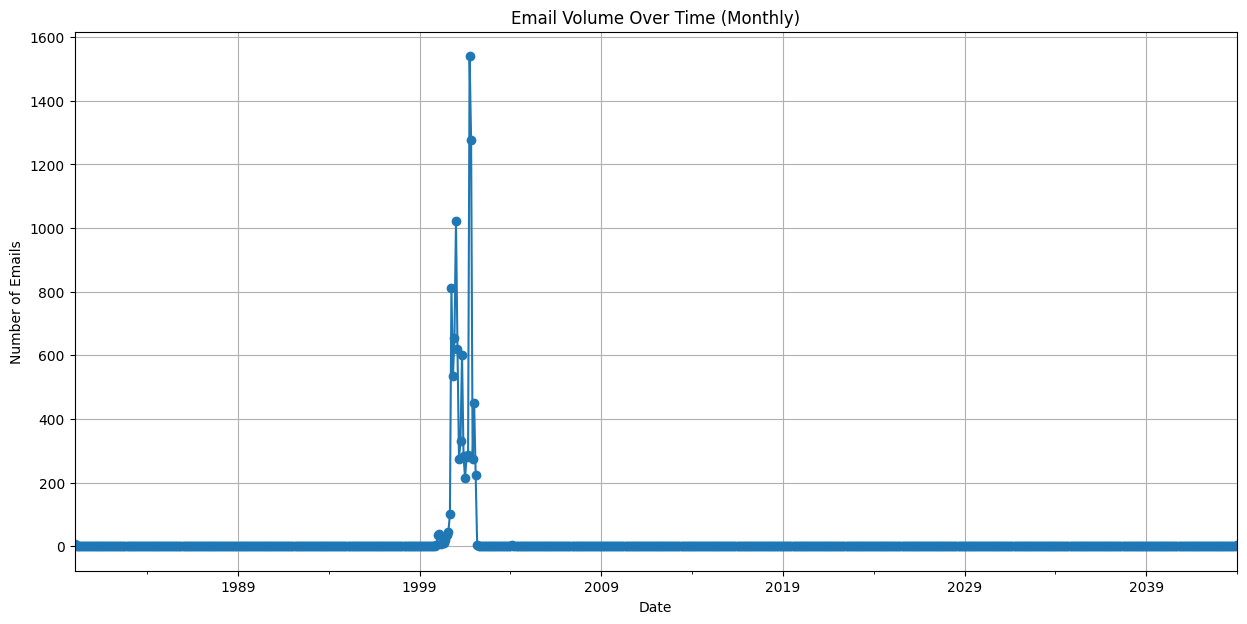

In [ ]:
if 'Date' not in df_emails.columns:

    if isinstance(df_emails.index, pd.DatetimeIndex):
        email_volume_by_month = df_emails.resample('M').size()
    else:
        print("The DataFrame index is not a DatetimeIndex. Please check the 'Date' column or the index.")
else:
    df_emails['Date'] = pd.to_datetime(df_emails['Date'], errors='coerce', utc=True)
    df_emails.set_index('Date', inplace=True)
    email_volume_by_month = df_emails.resample('M').size()

mdates=email_volume_by_month
# Plotting
plt.figure(figsize=(15, 7))
email_volume_by_month.plot(style="-o", title='Email Volume Over Time (Monthly)')
plt.ylabel('Number of Emails')
plt.xlabel('Date')
plt.grid(True)

# x-axis labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.xticks(rotation=45, ha='right')

# Tight layout
plt.tight_layout()

# Plot
plt.show()


<ipython-input-10-88eec55d4605>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_senders.values, y=top_senders.index, palette="Blues_d")
<ipython-input-10-88eec55d4605>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_recipients.values, y=top_recipients.index, palette="Greens_d")


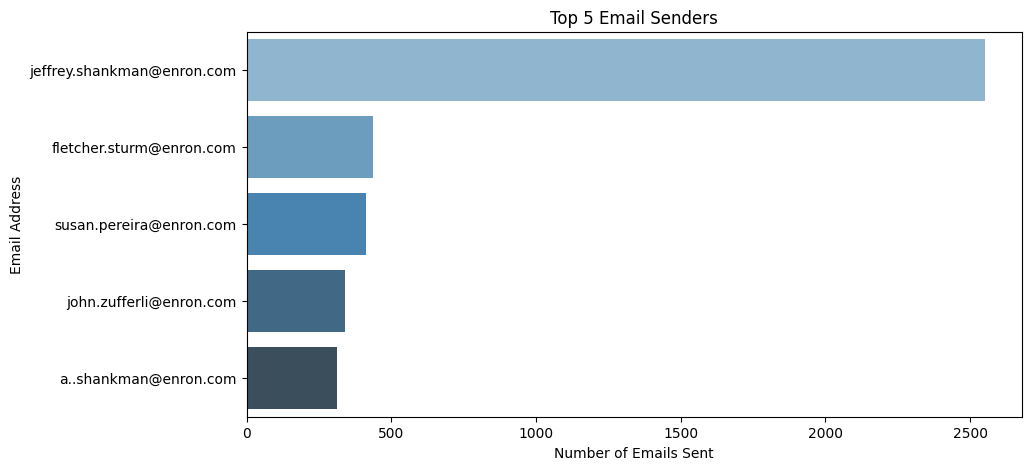

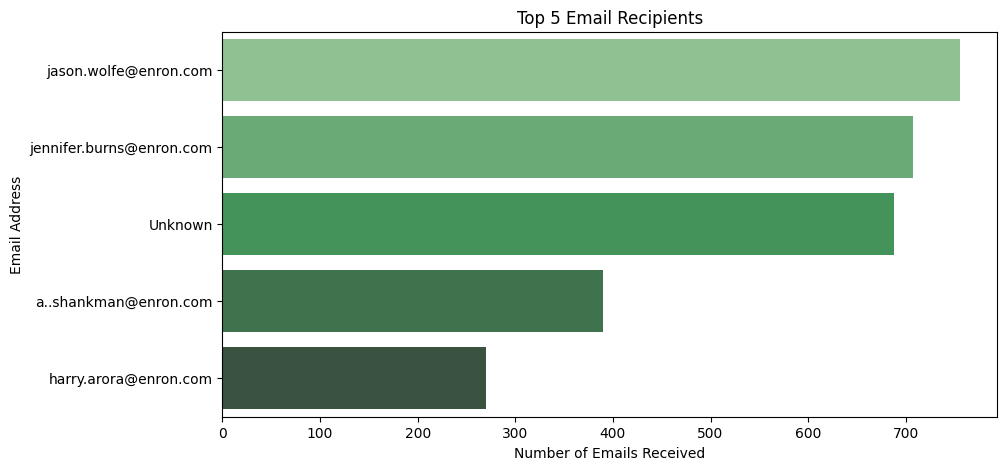

In [ ]:
#Top 5 Email Senders and Recipients
# Counting the occurrences of each sender and recipient
top_senders = df_emails['From'].value_counts().head(5)
top_recipients = df_emails['To'].fillna('Unknown').value_counts().head(5)

# Plotting the top senders
plt.figure(figsize=(10, 5))
sns.barplot(x=top_senders.values, y=top_senders.index, palette="Blues_d")
plt.title('Top 5 Email Senders')
plt.xlabel('Number of Emails Sent')
plt.ylabel('Email Address')

# Plotting the top recipients
plt.figure(figsize=(10, 5))
sns.barplot(x=top_recipients.values, y=top_recipients.index, palette="Greens_d")
plt.title('Top 5 Email Recipients')
plt.xlabel('Number of Emails Received')
plt.ylabel('Email Address')

plt.show()


In [ ]:
#Find and plot the pair that had the most emails between them

df_emails['Pair'] = df_emails.apply(lambda x: frozenset([x['From'], x['To']]), axis=1)

# Step 2: Count Occurrences of Each Pair
pair_counts = df_emails['Pair'].value_counts()

# Step 3: Identify the Pair with the Most Emails Exchanged
most_emails_pair = pair_counts.idxmax()
most_emails_count = pair_counts.max()

# Since the pair is a frozenset, we need to convert it to a readable format
most_emails_pair_list = list(most_emails_pair)

pair_readable = f"{most_emails_pair_list[0]} <--> {most_emails_pair_list[1]}" if len(most_emails_pair_list) > 1 else f"{most_emails_pair_list[0]} (self or unknown recipient)"

pair_readable, most_emails_count

('jeffrey.shankman@enron.com <--> jennifer.burns@enron.com', 675)

In [ ]:
#Feature Extraction
#Domain Extraction: Extract the email domain (@enron.com) as it might give insights into internal vs. external communication patterns
df_emails['Email Domain'] = df_emails['From'].str.split('@').str[1]
print(df_emails.head())

#Email length: Create a new varible for the length of the body of the email
df_emails['Email Length'] = df_emails['Body'].str.len()
print(df_emails.head())




                                                        From  \
Date                                                           
2001-05-13 19:37:00+00:00      enron.announcements@enron.com   
2001-04-03 15:44:07+00:00              a..shankman@enron.com   
2001-02-13 15:14:00+00:00  vic.gatto@owen2002.vanderbilt.edu   
2001-11-21 00:24:14+00:00             chance.rabon@enron.com   
2000-12-05 17:45:00+00:00            jeff.bartlett@enron.com   

                                                                          To  \
Date                                                                           
2001-05-13 19:37:00+00:00                            all.worldwide@enron.com   
2001-04-03 15:44:07+00:00                 pruskin@purskingallery.demon.co.uk   
2001-02-13 15:14:00+00:00                              harry.arora@enron.com   
2001-11-21 00:24:14+00:00  chuck.ames@enron.com, f..brawner@enron.com, ku...   
2000-12-05 17:45:00+00:00                              harry.arora@enro

In [ ]:
#Min-Max scaling to normalize its values between 0 and 1
min_value = df_emails['Email Length'].min()
max_value = df_emails['Email Length'].max()

df_emails['Email_Length_Normalized'] = (df_emails['Email Length'] - min_value) / (max_value - min_value)

# Display the updated dataframe to verify the new column
print(df_emails[['Email Length', 'Email_Length_Normalized']].head())

                           Email Length  Email_Length_Normalized
Date                                                            
2001-05-13 19:37:00+00:00           797                 0.003690
2001-04-03 15:44:07+00:00           195                 0.000903
2001-02-13 15:14:00+00:00           274                 0.001269
2001-11-21 00:24:14+00:00           100                 0.000463
2000-12-05 17:45:00+00:00            42                 0.000194


(array([  25.,   16.,   55.,  556., 4229., 4039.,  856.,  164.,   49.,
          11.]),
 array([-0.8 , -0.62, -0.44, -0.26, -0.08,  0.1 ,  0.28,  0.46,  0.64,
         0.82,  1.  ]),
 <BarContainer object of 10 artists>)

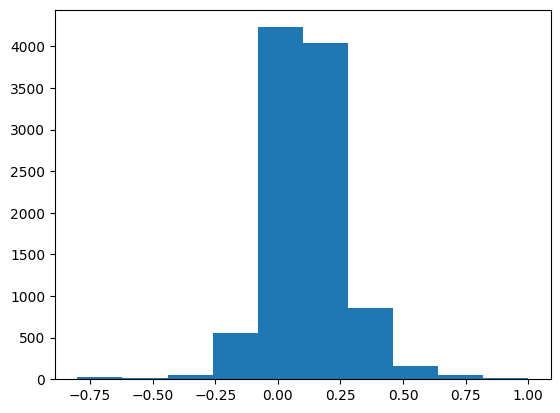

In [ ]:

import nltk
from nltk.corpus import stopwords
from nltk import bigrams
from textblob import TextBlob


comment = [TextBlob(email).sentiment.polarity for email in df_emails['Body']]
comment[:20]

plt.hist(comment)

#Sentiment Analysis
#The polarity score is a float that ranges from -1.0 to 1.0. Typically a polarity score below -0.5 is negative,
#a score above 0.5 is positive and a score in between is considered neutral.



(array([ 975.,  454., 1256., 2325., 2738., 1528.,  449.,  136.,   45.,
          94.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

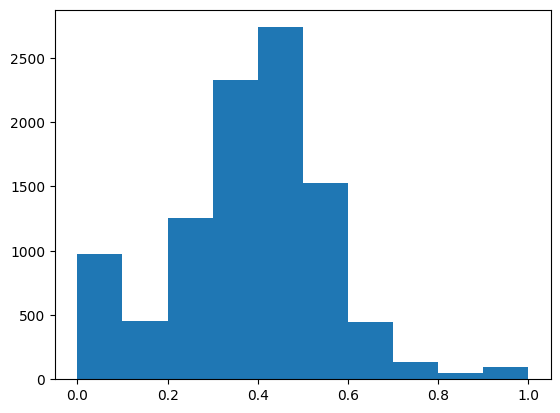

In [ ]:
#Sentiment Analysis
#The subjectivity score is a float that ranges between 0.0 and 1.0
#where the lower scores are very objective and the scores closer to 1.0 are very subjective.

comment2 = [TextBlob(email).sentiment.subjectivity for email in df_emails['Body']]
comment2[:20]

plt.hist(comment2)

In [ ]:
# Function to extract emails from a given text using regular expressions
def extract_emails(Comment):
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    return re.findall(email_pattern, Comment)

# Function to analyze sentiment using TextBlob
def analyze_sentiment(Comment):
    blob = TextBlob(Comment)
    return blob.sentiment.polarity

# Filter emails with negative sentiment scores less than .25
negative_emails = [email for email in df_emails['Body'] if analyze_sentiment(email) < -0.25]

# Display the filtered emails
print("Emails with Negative Polarity:")
for email in negative_emails:
    print(email)

Emails with Negative Polarity:
ads ny times wsj ft crude product traders jeff
request pending approval days please click http itcappscorpenroncomsrrsauthemaillinkasp pageapproval review act upon request request id request create date pm requested eriksimpson enroncom resource name market data kobra crude resource type applications
request pending approval days please click http itcappscorpenroncomsrrsauthemaillinkasp pageapproval review act upon request request id request create date pm requested eriksimpson enroncom resource name market data kobra crude resource type applications
print forwarded jeffrey shankmanhouect pm jennifer fraser pm jcole enroncom jeffrey shankmanhouect ect cc subject global petroleum monthly november wefa outlook crude products
jeffreyshankman enroncom mikemcconnell enroncom someone going return phone calls couple questions need answered next week using email outlook fucked weeks cant fix
email content jennifer fraser mike mcconnellhouect ect jeffrey shankmanh

In [ ]:
# Function to extract emails from a given text using regular expressions
def extract_emails(Comment):
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    return re.findall(email_pattern, Comment)

# Function to analyze sentiment using TextBlob
def analyze_sentiment(Comment):
    blob = TextBlob(Comment)
    return blob.sentiment.subjectivity

# Filter emails with positive subjectivity scores more than .8
positive_emails = [email for email in df_emails['Body'] if analyze_sentiment(email) > .8]

# Display the filtered emails
print("Emails with Positive Subjectivity:")
for email in positive_emails:
    print(email)

Emails with Positive Subjectivity:
invited attend ena trading track dinner tuesday october location details confirmed please rsvp attendance regards karen buckley
http wwwbestinnsnetusatxrdmermaidinnhtml http https cimarronnetusatxcopperhtml http wwwmilamhomecom beth cherry sr creative consultant enform technology
ads ny times wsj ft crude product traders jeff
latest copy rockies forecast meeting today cdt assuming guys send copy presenting jay
howdy stranger please go sometime want hear latest details jeff
howdy stranger please go sometime want hear latest details jeff
one perfectly centered scan well hi ebay rating
request pending approval days please click http itcappscorpenroncomsrrsauthemaillinkasp pageapproval review act upon request request id request create date pm requested eriksimpson enroncom resource name market data kobra crude resource type applications
request pending approval days please click http itcappscorpenroncomsrrsauthemaillinkasp pageapproval review act upon req

In [ ]:

def filter_texts_with_word(texts, word):
    filtered_texts = [text for text in df_emails['Body'] if word.lower() in TextBlob(text).lower()]
    return filtered_texts

# Word to search for in texts
search_word = "jail"

# Filter texts containing the word
texts_with_word = filter_texts_with_word(df_emails['Body'], search_word)

# Print the filtered texts
print("Texts containing the word '{}'".format(search_word))
for text in texts_with_word:
    print(text)

Texts containing the word 'jail'
newsweek cover enron burned pr newswire enron chief misled employees waxman says inquiry kenneth lay emails painted bright future firm even stock faltering los angeles times world school scandal trying pass damage control new york times bush enron chief rose circles achievement associated press newswires enron collapse complex web relationships boom bust new york times enron collapse debacle enron insiders cashed billion shares new york times enron auditing firm destroyed documents cnn sunday usa us senator enron accountant could face charges reuters english news service enron gave schumer donations largest senate democrat newsday enron echoes past scandals chicago tribune learning enron washington post nation news analysis white house failure sound alarm faulted warnings issued enron collapsed raises specter special treatment critics charge los angeles times interview john dingell tom davis fox news fox news sunday interview paul oneill fox news fox ne

In [ ]:
# Keywords
keywords = ["Fraud", "Fraudulent", "Manipulation", "Insider Trading", "Embezzlement", "Bribery", "Bribe",
            "Kickback", "Shell Company", "Laundering", "Offshore Accounts", "Cook the Books",
            "Misrepresentation", "Backdating", "Whistleblower", "Whistleblowing", "Conflict of Interest",
            "Falsify", "Falsification", "Unethical Practice", "Regulatory Investigation", "Regulatory Inquiry",
            "Market Manipulation", "Phantom Revenue", "Round-Tripping", "Special Purpose Entities",
            "Creative Accounting", "Audit Issues", "Auditing Issues", "Compliance Issues", "Ethics Violation",
            "Securities Fraud", "Tax Evasion"]

keywords_lower = [word.lower() for word in keywords]

# Function
def contains_keyword(text):
    if pd.isnull(text):
        return 0
    text = text.lower()
    return any(keyword in text for keyword in keywords_lower)

df_emails['Fraud_Flag'] = df_emails.apply(lambda row: contains_keyword(row['Subject']) or contains_keyword(row['Body']), axis=1)

# Verify
print(df_emails[['Subject', 'Body', 'Fraud_Flag']].head())


                                                                    Subject  \
Date                                                                          
2001-05-13 19:37:00+00:00        Espeak with Fitness Expert, Dr. Joel Bloom   
2001-04-03 15:44:07+00:00                                                     
2001-02-13 15:14:00+00:00                                         Thank You   
2001-11-21 00:24:14+00:00  TRV Notification: (East P/L Totals - 11/20/2001)   
2000-12-05 17:45:00+00:00                   JMB Deal Summary Sheet for 2000   

                                                                        Body  \
Date                                                                           
2001-05-13 19:37:00+00:00  ever wonder sports drink like gatorade work mu...   
2001-04-03 15:44:07+00:00  hi sarah thanks fax dunand tea set still resea...   
2001-02-13 15:14:00+00:00  harry thank taking time last week meet arrangi...   
2001-11-21 00:24:14+00:00  report named east p

In [ ]:
# final_df
final_df = df_emails.copy()
final_df = df_emails[['Subject', 'Body', 'Fraud_Flag', 'Email Domain', 'Email Length', 'Email_Length_Normalized']].copy()

# Display
print(final_df.head())


                                                                    Subject  \
Date                                                                          
2001-05-13 19:37:00+00:00        Espeak with Fitness Expert, Dr. Joel Bloom   
2001-04-03 15:44:07+00:00                                                     
2001-02-13 15:14:00+00:00                                         Thank You   
2001-11-21 00:24:14+00:00  TRV Notification: (East P/L Totals - 11/20/2001)   
2000-12-05 17:45:00+00:00                   JMB Deal Summary Sheet for 2000   

                                                                        Body  \
Date                                                                           
2001-05-13 19:37:00+00:00  ever wonder sports drink like gatorade work mu...   
2001-04-03 15:44:07+00:00  hi sarah thanks fax dunand tea set still resea...   
2001-02-13 15:14:00+00:00  harry thank taking time last week meet arrangi...   
2001-11-21 00:24:14+00:00  report named east p

In [ ]:
# Positives
positive_frauds = final_df['Fraud_Flag'].sum()
print(f"Number of positive fraud flags: {positive_frauds}")


Number of positive fraud flags: 43


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2001-10-03 13:59:50+00:00 to 2002-01-11 15:54:22+00:00
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Subject                  10000 non-null  object 
 1   Body                     10000 non-null  object 
 2   Fraud_Flag               10000 non-null  bool   
 3   Email Domain             10000 non-null  object 
 4   Email Length             10000 non-null  int64  
 5   Email_Length_Normalized  10000 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 478.5+ KB


In [ ]:
df_emails['Sentiment_Polarity'] = df_emails['Body'].apply(lambda x: TextBlob(x).sentiment.polarity if pd.notnull(x) else None)
final_df['Sentiment Polarity'] = df_emails['Sentiment_Polarity']

df_emails['Subjectivity_Score'] = df_emails['Body'].apply(lambda x: TextBlob(x).sentiment.subjectivity if pd.notnull(x) else None)
final_df['Subjectivity Score'] = df_emails['Subjectivity_Score']


# Verify
print(final_df.head())
final_df.info()

                                                                    Subject  \
Date                                                                          
2001-05-13 19:37:00+00:00        Espeak with Fitness Expert, Dr. Joel Bloom   
2001-04-03 15:44:07+00:00                                                     
2001-02-13 15:14:00+00:00                                         Thank You   
2001-11-21 00:24:14+00:00  TRV Notification: (East P/L Totals - 11/20/2001)   
2000-12-05 17:45:00+00:00                   JMB Deal Summary Sheet for 2000   

                                                                        Body  \
Date                                                                           
2001-05-13 19:37:00+00:00  ever wonder sports drink like gatorade work mu...   
2001-04-03 15:44:07+00:00  hi sarah thanks fax dunand tea set still resea...   
2001-02-13 15:14:00+00:00  harry thank taking time last week meet arrangi...   
2001-11-21 00:24:14+00:00  report named east p

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Separate features and target variable
X = final_df.drop(columns=['Fraud_Flag'])
y = final_df['Fraud_Flag']

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('text', TfidfVectorizer(), text_features)
    ]
)

# Pipeline that combines the preprocessor with a classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Training and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate pipeline
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predictions on test data
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluate with multiple metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Output the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Cross-validate pipeline
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
print(f'Cross-validated Accuracy: {cv_scores.mean():.4f}')


Accuracy: 0.9965
Confusion Matrix:
[[1987    0]
 [   7    6]]
Precision: 1.0000
Recall: 0.4615
F1 Score: 0.6316
ROC AUC: 0.9966
Cross-validated Accuracy: 0.9979


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Split the data
X = final_df.drop('Fraud_Flag', axis=1)
y = final_df['Fraud_Flag']

# Models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SVC': SVC(probability=True)
}

# CV
cv_results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    cv_results[model_name] = scores
    print(f"{model_name}: {scores.mean():.3f} (+/- {scores.std():.3f})")


LogisticRegression: 0.996 (+/- 0.000)
RandomForest: 0.998 (+/- 0.000)
GradientBoosting: 0.999 (+/- 0.000)
SVC: 0.997 (+/- 0.000)


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")


True Positives: 6
False Positives: 0
True Negatives: 1987
False Negatives: 7
